# NLP & Sentiment with News Headlines

In [2]:
# custom imports
import loadArticles
import loadStockInfo
import textProcessing

In [1]:
import pandas as pd
import numpy as np

#text processing
import string
import en_core_web_lg
from spacy.gold import GoldParse
from spacy.pipeline import EntityRecognizer
from spacy.tokens import Doc
from spacy.pipeline import EntityRuler

In [2]:
#sklearn imports
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
#plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#load in news/sentiment data
news_sent_by_ticker = pd.read_csv("../../data/news/final_news_sent.csv")
#change date to datetime object
news_sent_by_ticker['date'] = pd.to_datetime(pd.to_datetime(news_sent_by_ticker['date'], utc=True).dt.date)
#change sentimet

In [7]:
#Label Encoding of Sentiment
label_encoder = LabelEncoder()
news_sent_by_ticker['sentiment_value'] = label_encoder.fit_transform(news_sent_by_ticker['sentiment'])

In [8]:
#one hot encoding of sentiment
c = OneHotEncoder()
one_hot_df = pd.DataFrame(encoder.fit_transform(news_sent_by_ticker[['sentiment_value']]).toarray())

NameError: name 'encoder' is not defined

In [ ]:
news_sent_by_ticker = news_sent_by_ticker.join(one_hot_df)
news_sent_by_ticker.columns = ['ticker', 'title', 'sentiment', 'date', 'sentiment_value', 'is_negative', 'is_neutral', 'is_positive']

In [ ]:
news_sent_by_ticker

In [5]:
# news_sent_by_ticker['sentiment'] = np.where(news_sent_by_ticker['sentiment']=='Neutral', 0, news_sent_by_ticker['sentiment'])
# news_sent_by_ticker['sentiment'] = np.where(news_sent_by_ticker['sentiment']=='Positive', 1, news_sent_by_ticker['sentiment'])
# news_sent_by_ticker['sentiment'] = np.where(news_sent_by_ticker['sentiment']=='Negative', 2, news_sent_by_ticker['sentiment'])

In [ ]:
#load in stock data purely to be used to enhance the rules for entity detection in the spacy nlp
stockInfo = loadStockInfo.loadStockInfo('../../data/stock-market-dataset/stocks/', '../../data/stock-market-dataset/symbols_valid_meta.csv', DEBUG=True)
stock_meta_df = pd.read_csv('../../data/stock-market-dataset/symbols_valid_meta.csv', index_col=0)
stock_meta_df['Tag'] = 'ORG'
symbol_df = stock_meta_df[stock_meta_df['ETF'] == 'N']['NASDAQ Symbol']
symbol_df.reset_index(inplace=True, drop=True)

Distribution of Sentiment

In [ ]:
plt.figure(figsize=(15,12))
sns.barplot(x=news_sent_by_ticker['sentiment'].value_counts().index, y=news_sent_by_ticker['sentiment'].value_counts())
plt.xlabel("Sentiment", size=14)
plt.ylabel("Number of Headlines", size=14)
plt.title("Count of Headlines by Sentiment", size=18)
plt.show()

In [ ]:
#improving text processing spacy tokenizer
#create more fine tuned nlp rules for spacy
#get entities from article headline
nlp = en_core_web_lg.load()
ruler = EntityRuler(nlp)

#creating pattersn for entity ruler
temp_df1 = stock_meta_df[['Tag', 'Symbol']]
temp_df1.columns = ['label', 'pattern']
temp_df2 = stock_meta_df[['Tag', 'Name']]
temp_df2.columns = ['label', 'pattern']

temp_df = pd.concat([temp_df1, temp_df2])

#set patterns
patterns = temp_df.to_dict('records')
#add patterns to ruler
ruler.add_patterns(patterns)
#add ruler to nlp
nlp.add_pipe(ruler)

tp = textProcessing.textProcessing(nlp)

In [4]:
#spacy tokenize function to use for countvectorizer and TF-IDF
#create tokenizing function
def tokenizeSpacy(sentence):
    try:
        for punctuation_mark in string.punctuation:
            # Remove punctuation and set to lower case
            sentence = sentence.replace(punctuation_mark,'').lower()

        doc = nlp(sentence)

        listofwords = list()
        for token in doc:
           
            if not token.is_stop:
                if token.is_alpha:
                    listofwords.append(token.lemma_.strip().lower())

        return listofwords
    except Exception as e:
        print(f"Something went wrong in tokenizeSpacy: {e}")

## Train, Test Split

In [36]:
#split data
X = news_sent_by_ticker['title']
y = news_sent_by_ticker['sentiment_value']

In [37]:
#train test, validate split
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_validate, y_train, y_validate = train_test_split(X_remainder, y_remainder, test_size=0.3, random_state=1)

## CountVectorizer

In [40]:
#countvectorize model using a max 1000 feautres
countVectorizer = CountVectorizer(tokenizer=tokenizeSpacy, min_df=10, ngram_range=(1,3), max_features=1000)

In [42]:
countVectorizer.fit(X_train)
#transform with CountVectorizer
X_train_cv = countVectorizer.transform(X_train)
X_validate_cv = countVectorizer.transform(X_validate)

/Users/jjackson/opt/anaconda3/envs/BrainStationCapstone/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [46]:
X_train_cv_df = pd.DataFrame(X_train_cv.toarray(), columns=countVectorizer.get_feature_names())
X_validate_cv_df = pd.DataFrame(X_validate_cv.toarray(), columns=countVectorizer.get_feature_names())

## TF-IDF Vectorizer

In [50]:
tfidf = TfidfVectorizer(max_features=1000, min_df=10, tokenizer=tokenizeSpacy, ngram_range = (1,3))

In [55]:
#fit TF-IDF model with training data
tfidf.fit(X_train)
#transform with TF-IDF
X_train_tfidf = tfidf.transform(X_train)
X_validate_tfidf = tfidf.transform(X_validate)

/Users/jjackson/opt/anaconda3/envs/BrainStationCapstone/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [93]:
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names())
X_validate_tfidf_df = pd.DataFrame(X_validate_tfidf.toarray(), columns=tfidf.get_feature_names())

## Custom Word Embeddings

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import model_from_json
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phrases, Phraser

In [13]:
#tokenize with tensorflow
tk = Tokenizer(lower=True, filters=string.punctuation, split=' ')
#fit tokenizer
tk.fit_on_texts(news_sent_by_ticker['title'])

In [14]:
#set max_len of article headlines
max_len = 25
#get tokenized titles
tokenized_title = tk.texts_to_sequences(news_sent_by_ticker[news_sent_by_ticker['sentiment_value'] != 1]['title'])
tokenized_title_X = pad_sequences(tokenized_title, maxlen=max_len)

In [12]:
# #train test split on new tk vectors
# X_train, X_test, y_train, y_test = train_test_split(tokenized_title_X, news_sent_by_ticker[news_sent_by_ticker['sentiment_value'] != 1]['sentiment_value'], test_size=0.2, random_state=1)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

(146249, 25) (146249,)
(36563, 25) (36563,)


In [ ]:
#set up a tensorflow keras neural networkd
embed_dim = 150
lstm_out = 200
max_features = tokenized_title_X.max() + 1
learnRate = 0.001
warmup_epoch = 20

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = tokenized_title_X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1,activation='softmax'))


model.compile(loss = 'binary_crosentropy',
              optimizer='adam',
              metrics = ['accuracy'])
model.summary()

## Pre-Trained Models

In [141]:
#load model for pre trained models
filename = "../../data/bi-gram-model.txt"
model = KeyedVectors.load_word2vec_format(filename, binary=False)
embed_size = 250
max_features = 10000

def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

#get embedding matrix
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(filename))
word_index = tk.word_index

nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))

#create embedded word vectors
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
#Neural Network for pre trained model
inp = Input(shape = (max_len,))
x = Embedding(nb_words+1, embed_size, weights = [embedding_matrix], trainable=False)(inp)
x = Dropout(0.3)(x)
x = LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5)(x)
x = Dense(1, activation="softmax")

model = Model(inputs=inp, outputs=x)

model.compile(loss='binary_crosdentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

## Logistic Regression

In [62]:
print_line = "\n=======================================================\n"

In [63]:
lr_model = LogisticRegression(C=0.1, max_iter=1000)

In [77]:
# CountVectorize LogisticRegression Model
lr_model.fit(X_train_cv_df[(y_train != 1).reset_index(drop=True)], y_train[y_train != 1])

LogisticRegression(C=0.1, max_iter=1000)

In [79]:
#get predicted
y_pred = lr_model.predict(X_validate_cv_df[(y_validate != 1).reset_index(drop=True)])
report_test = classification_report(y_validate[y_validate != 1], y_pred)

print("Valid Confusion Matrix for CountVectorizer:", print_line, confusion_matrix(y_validate[y_validate != 1], y_pred))
print("\nValid Data Classification Report for CountVectorizer:", print_line, report_test)

Valid Confusion Matrix for CountVectorizer: 
 [[ 8326  3353]
 [ 1286 30855]]

Valid Data Classification Report for CountVectorizer: 
               precision    recall  f1-score   support

           0       0.87      0.71      0.78     11679
           2       0.90      0.96      0.93     32141

    accuracy                           0.89     43820
   macro avg       0.88      0.84      0.86     43820
weighted avg       0.89      0.89      0.89     43820



In [95]:
# TF-IDF Logisitc Regression Model
lr_model.fit(X_train_tfidf_df[(y_train != 1).reset_index(drop=True)], y_train[y_train != 1])

LogisticRegression(C=0.1, max_iter=1000)

In [96]:
#get predicted
y_pred = lr_model.predict(X_validate_tfidf_df[(y_validate != 1).reset_index(drop=True)])
report_test = classification_report(y_validate[y_validate != 1], y_pred)

print("Valid Confusion Matrix for TF-IDF:", print_line, confusion_matrix(y_validate[y_validate != 1], y_pred))
print("\nValid Data Classification Report for TF-IDF:", print_line, report_test)

Valid Confusion Matrix for TF-IDF: 
 [[ 7919  3760]
 [ 1048 31093]]

Valid Data Classification Report for TF-IDF: 
               precision    recall  f1-score   support

           0       0.88      0.68      0.77     11679
           2       0.89      0.97      0.93     32141

    accuracy                           0.89     43820
   macro avg       0.89      0.82      0.85     43820
weighted avg       0.89      0.89      0.89     43820



## BackTrader

In [18]:
import backtrader as bt
import os
import sys
import datetime

In [19]:
fb_date_sent = news_sent_by_ticker.query("ticker == 'FB'")

In [20]:
fb_date_sent['sentiment_value'] = np.where(fb_date_sent['sentiment_value'] == 0, -1, fb_date_sent['sentiment_value'])
fb_date_sent['sentiment_value'] = np.where(fb_date_sent['sentiment_value'] == 1, 0, fb_date_sent['sentiment_value'])
fb_date_sent['sentiment_value'] = np.where(fb_date_sent['sentiment_value'] == 2, 1, fb_date_sent['sentiment_value'])

/Users/jjackson/opt/anaconda3/envs/BrainStationCapstone/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jjackson/opt/anaconda3/envs/BrainStationCapstone/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jjackson/opt/anaconda3/envs/BrainStationCapstone/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying t

In [21]:
date_sentiment_df = fb_date_sent.groupby('date').mean()['sentiment_value']

In [22]:
date_sentiment_df = date_sentiment_df.astype({'sentiment_value':'float'})
date_sentiment_df = date_sentiment_df.to_dict()

In [23]:
date_sentiment = {}

for k in date_sentiment_df:
    date_sentiment[pd.to_datetime(k).date()] = round(date_sentiment_df[k],3)

earliest_date = min(date_sentiment.keys())

In [24]:
stockInfo = loadStockInfo.loadStockInfo('../../data/stock-market-dataset/stocks/','../../data/stock-market-dataset/symbols_valid_meta.csv', DEBUG=True)
stock_df = stockInfo.loadStockDf()
stock_meta_df = pd.read_csv('../../data/stock-market-dataset/symbols_valid_meta.csv', index_col=0)
symbol_df = stock_meta_df[stock_meta_df['ETF'] == 'N']['NASDAQ Symbol']

In [25]:
stock_df.columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'symbol', 'name']

In [26]:
fb_stock_example = stock_df.query('symbol == "FB"')[['date', 'high', 'low', 'open', 'close', 'volume', 'adj_close']]

In [27]:
fb_stock_example['date'] = pd.to_datetime(fb_stock_example['date'])

In [28]:
fb_stock_example.query('date > "2018-01-01"').set_index('date')

,high,low,open,close,volume,adj_close
date,,,,,,
2018-01-02,181.580002,177.550003,177.679993,181.419998,18151900.0,181.419998
2018-01-03,184.779999,181.330002,181.880005,184.669998,16886600.0,184.669998
2018-01-04,186.210007,184.100006,184.899994,184.330002,13880900.0,184.330002
2018-01-05,186.899994,184.929993,185.589996,186.850006,13574500.0,186.850006
2018-01-08,188.899994,186.330002,187.199997,188.279999,17994700.0,188.279999
...,...,...,...,...,...,...
2020-03-26,164.000000,157.020004,158.250000,163.339996,26556800.0,163.339996
2020-03-27,160.089996,154.750000,158.199997,156.789993,24879900.0,156.789993
2020-03-30,166.750000,158.059998,159.179993,165.949997,22515200.0,165.949997


Starting Portfolio Value: 100000.00
2020-04-01, (MA Period 15) Ending Value 100243.30
Final Portfolio Value: 100243.30


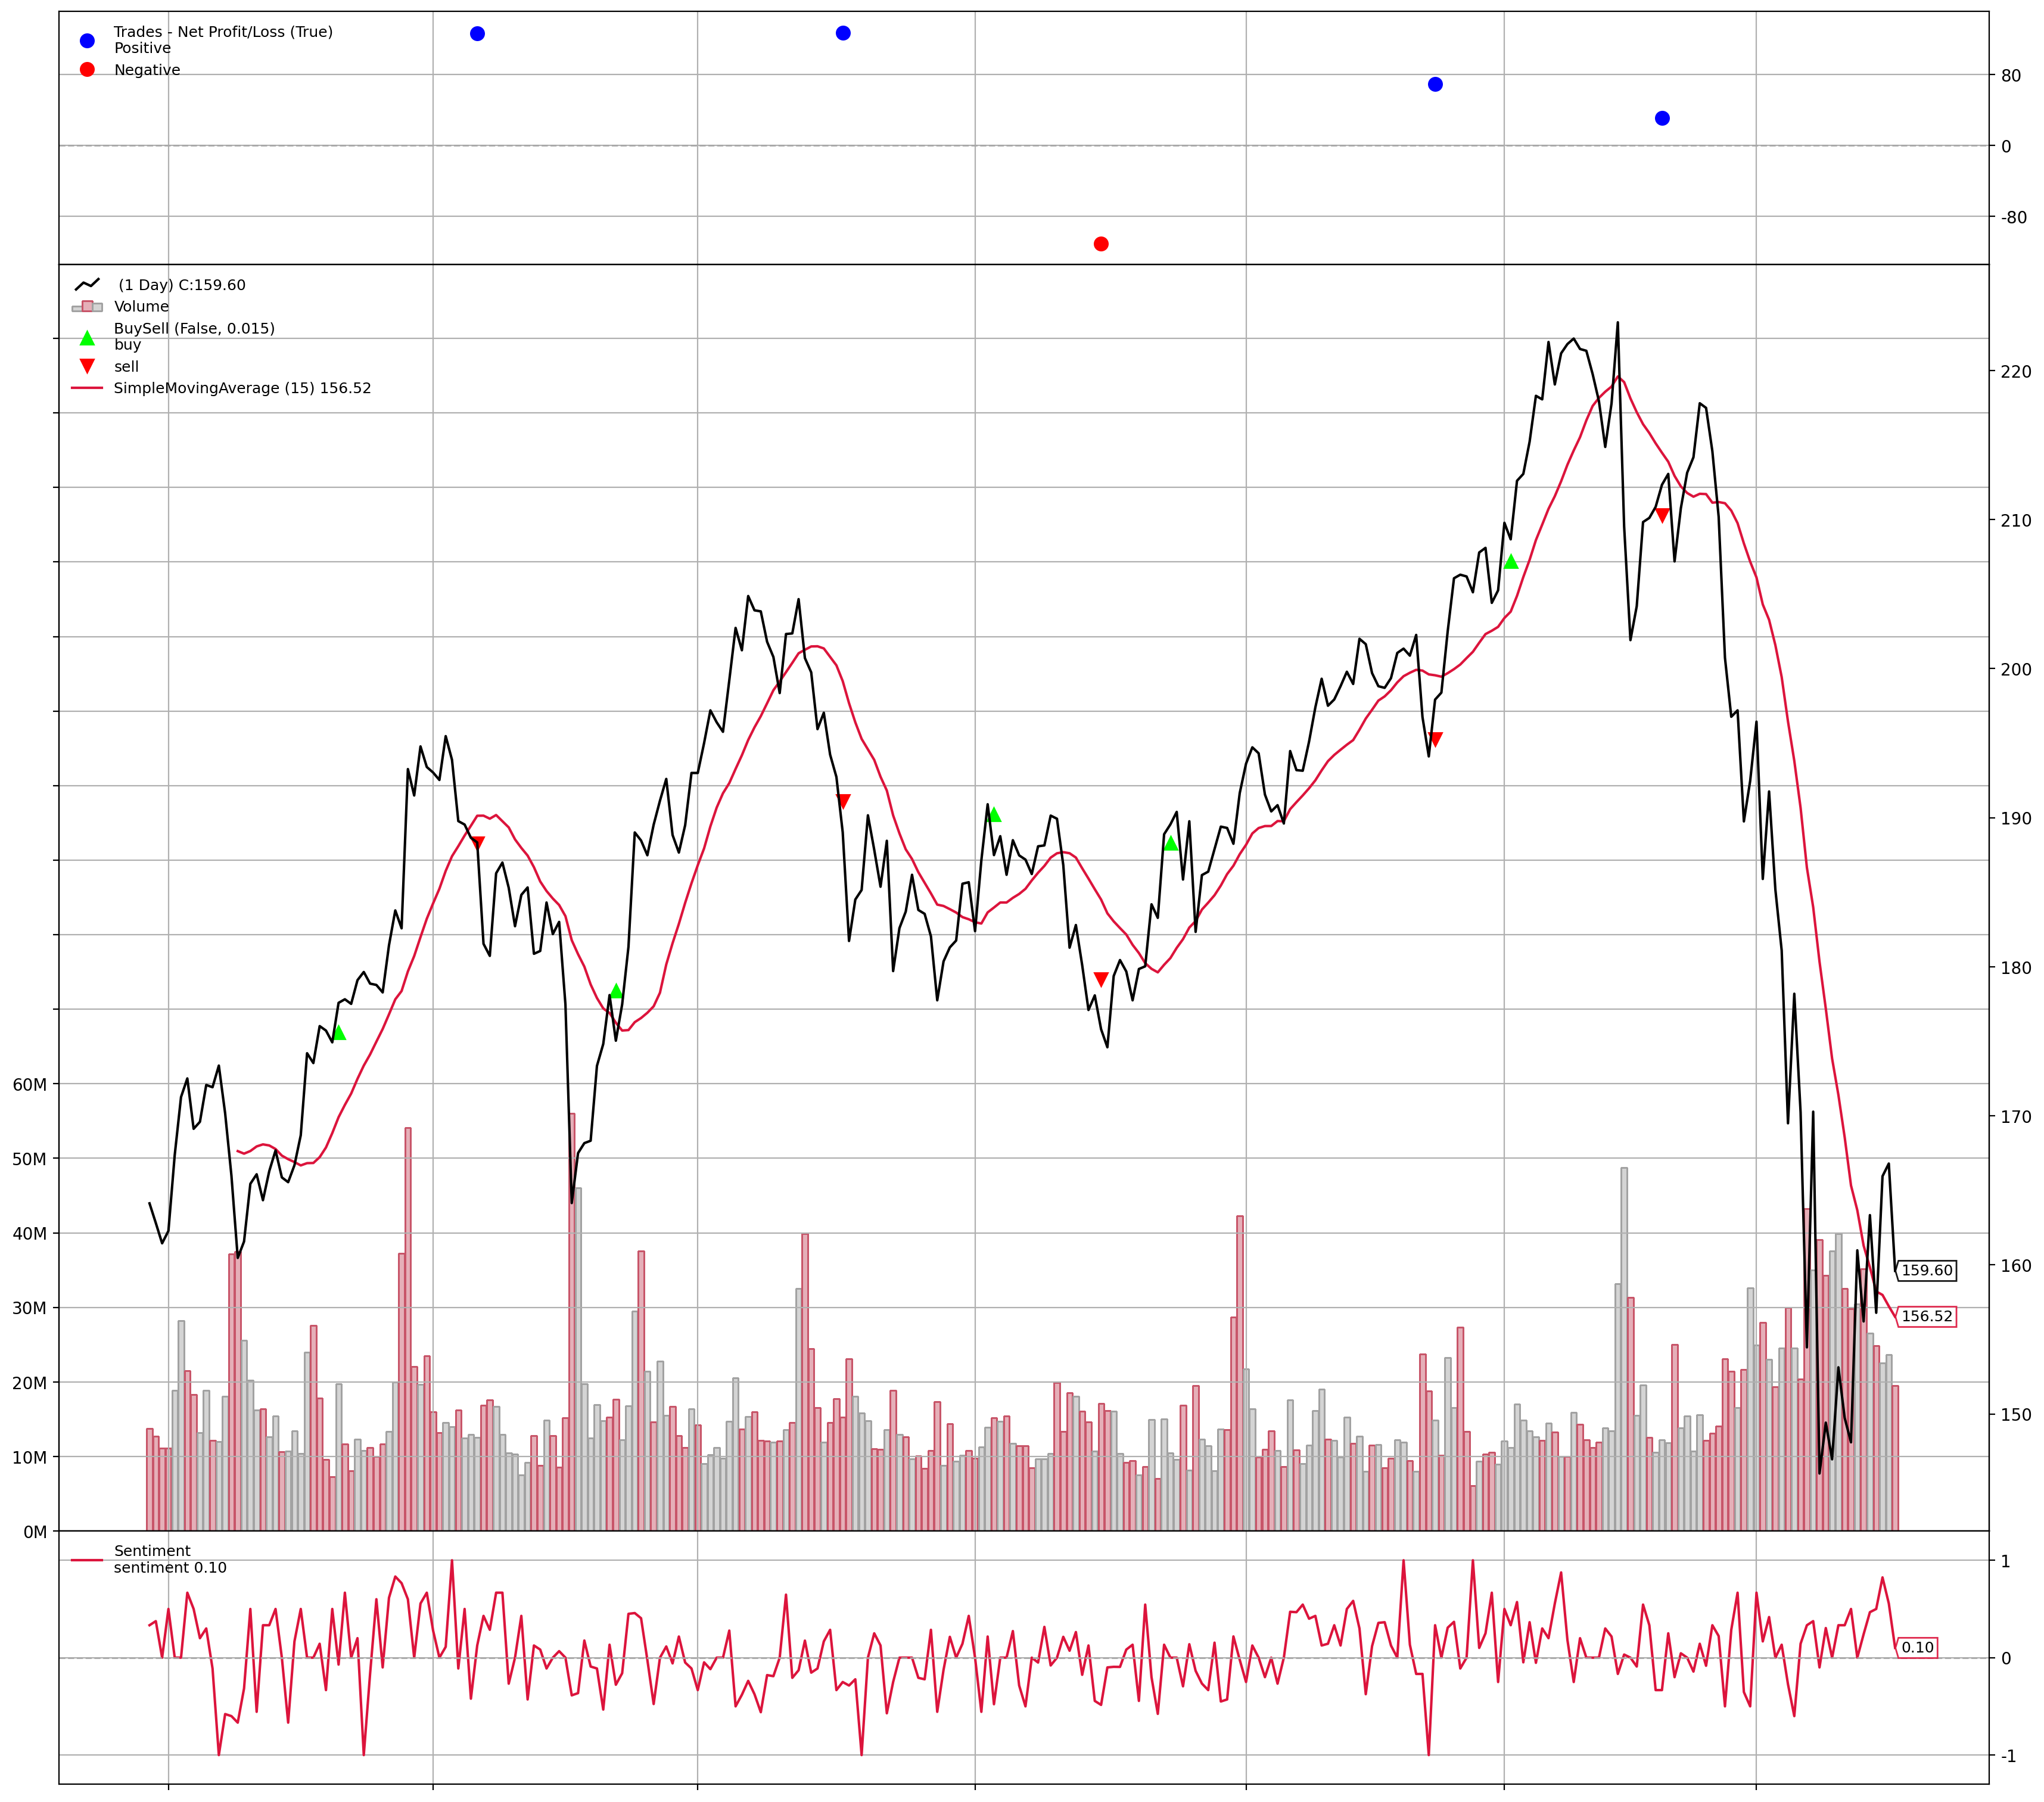

In [39]:
# Credit for this Class implementation
# Found through medium post - 
# https://towardsdatascience.com/https-towardsdatascience-com-algorithmic-trading-using-sentiment-analysis-on-news-articles-83db77966704
# Written by Jason Yip

from __future__ import (absolute_import, division, print_function,
                            unicode_literals)

%matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')

import backtrader as bt
import backtrader.indicators as btind
import datetime
import os.path
import sys

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.15,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        else:
            self.sentiment = 0.0
        self.lines.sentiment[0] = self.sentiment



class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):
        # log closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            # buy if current close more than sma AND sentiment increased by >= 0.5
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
                self.log('BUY CREATE, %.2f - SENTIMENT %.2f' % (self.dataclose[0], (self.sentiment - prev_sentiment)))
                self.order = self.buy()
                
        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            # sell if current close less than sma AND sentiment decreased by >= 0.5
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log('SELL CREATE, %.2f - SENTIMENT %.2f' % (self.dataclose[0], (self.sentiment - prev_sentiment)))
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' % (self.params.period, self.broker.getvalue()), doprint=True)
        

if __name__ == '__main__':
    
    cerebro = bt.Cerebro(stdstats=False)
    
    # Strategy
    cerebro.addstrategy(SentimentStrat)

    # Data Feed
    data = bt.feeds.PandasData(dataname=fb_stock_example.query('date > "2019-02-25"').set_index('date'))
    
    cerebro.adddata(data)

    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.addobserver(bt.observers.Trades)
    cerebro.addobserver(bt.observers.BuySell)
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    plt.rcParams['figure.figsize']=[18, 16]
    plt.rcParams['figure.dpi']=200
    plt.rcParams['figure.facecolor']='w'
    plt.rcParams['figure.edgecolor']='k'

    cerebro.plot(iplot=False)

<IPython.core.display.Javascript object>

[[<Figure size 3600x3200 with 4 Axes>]]

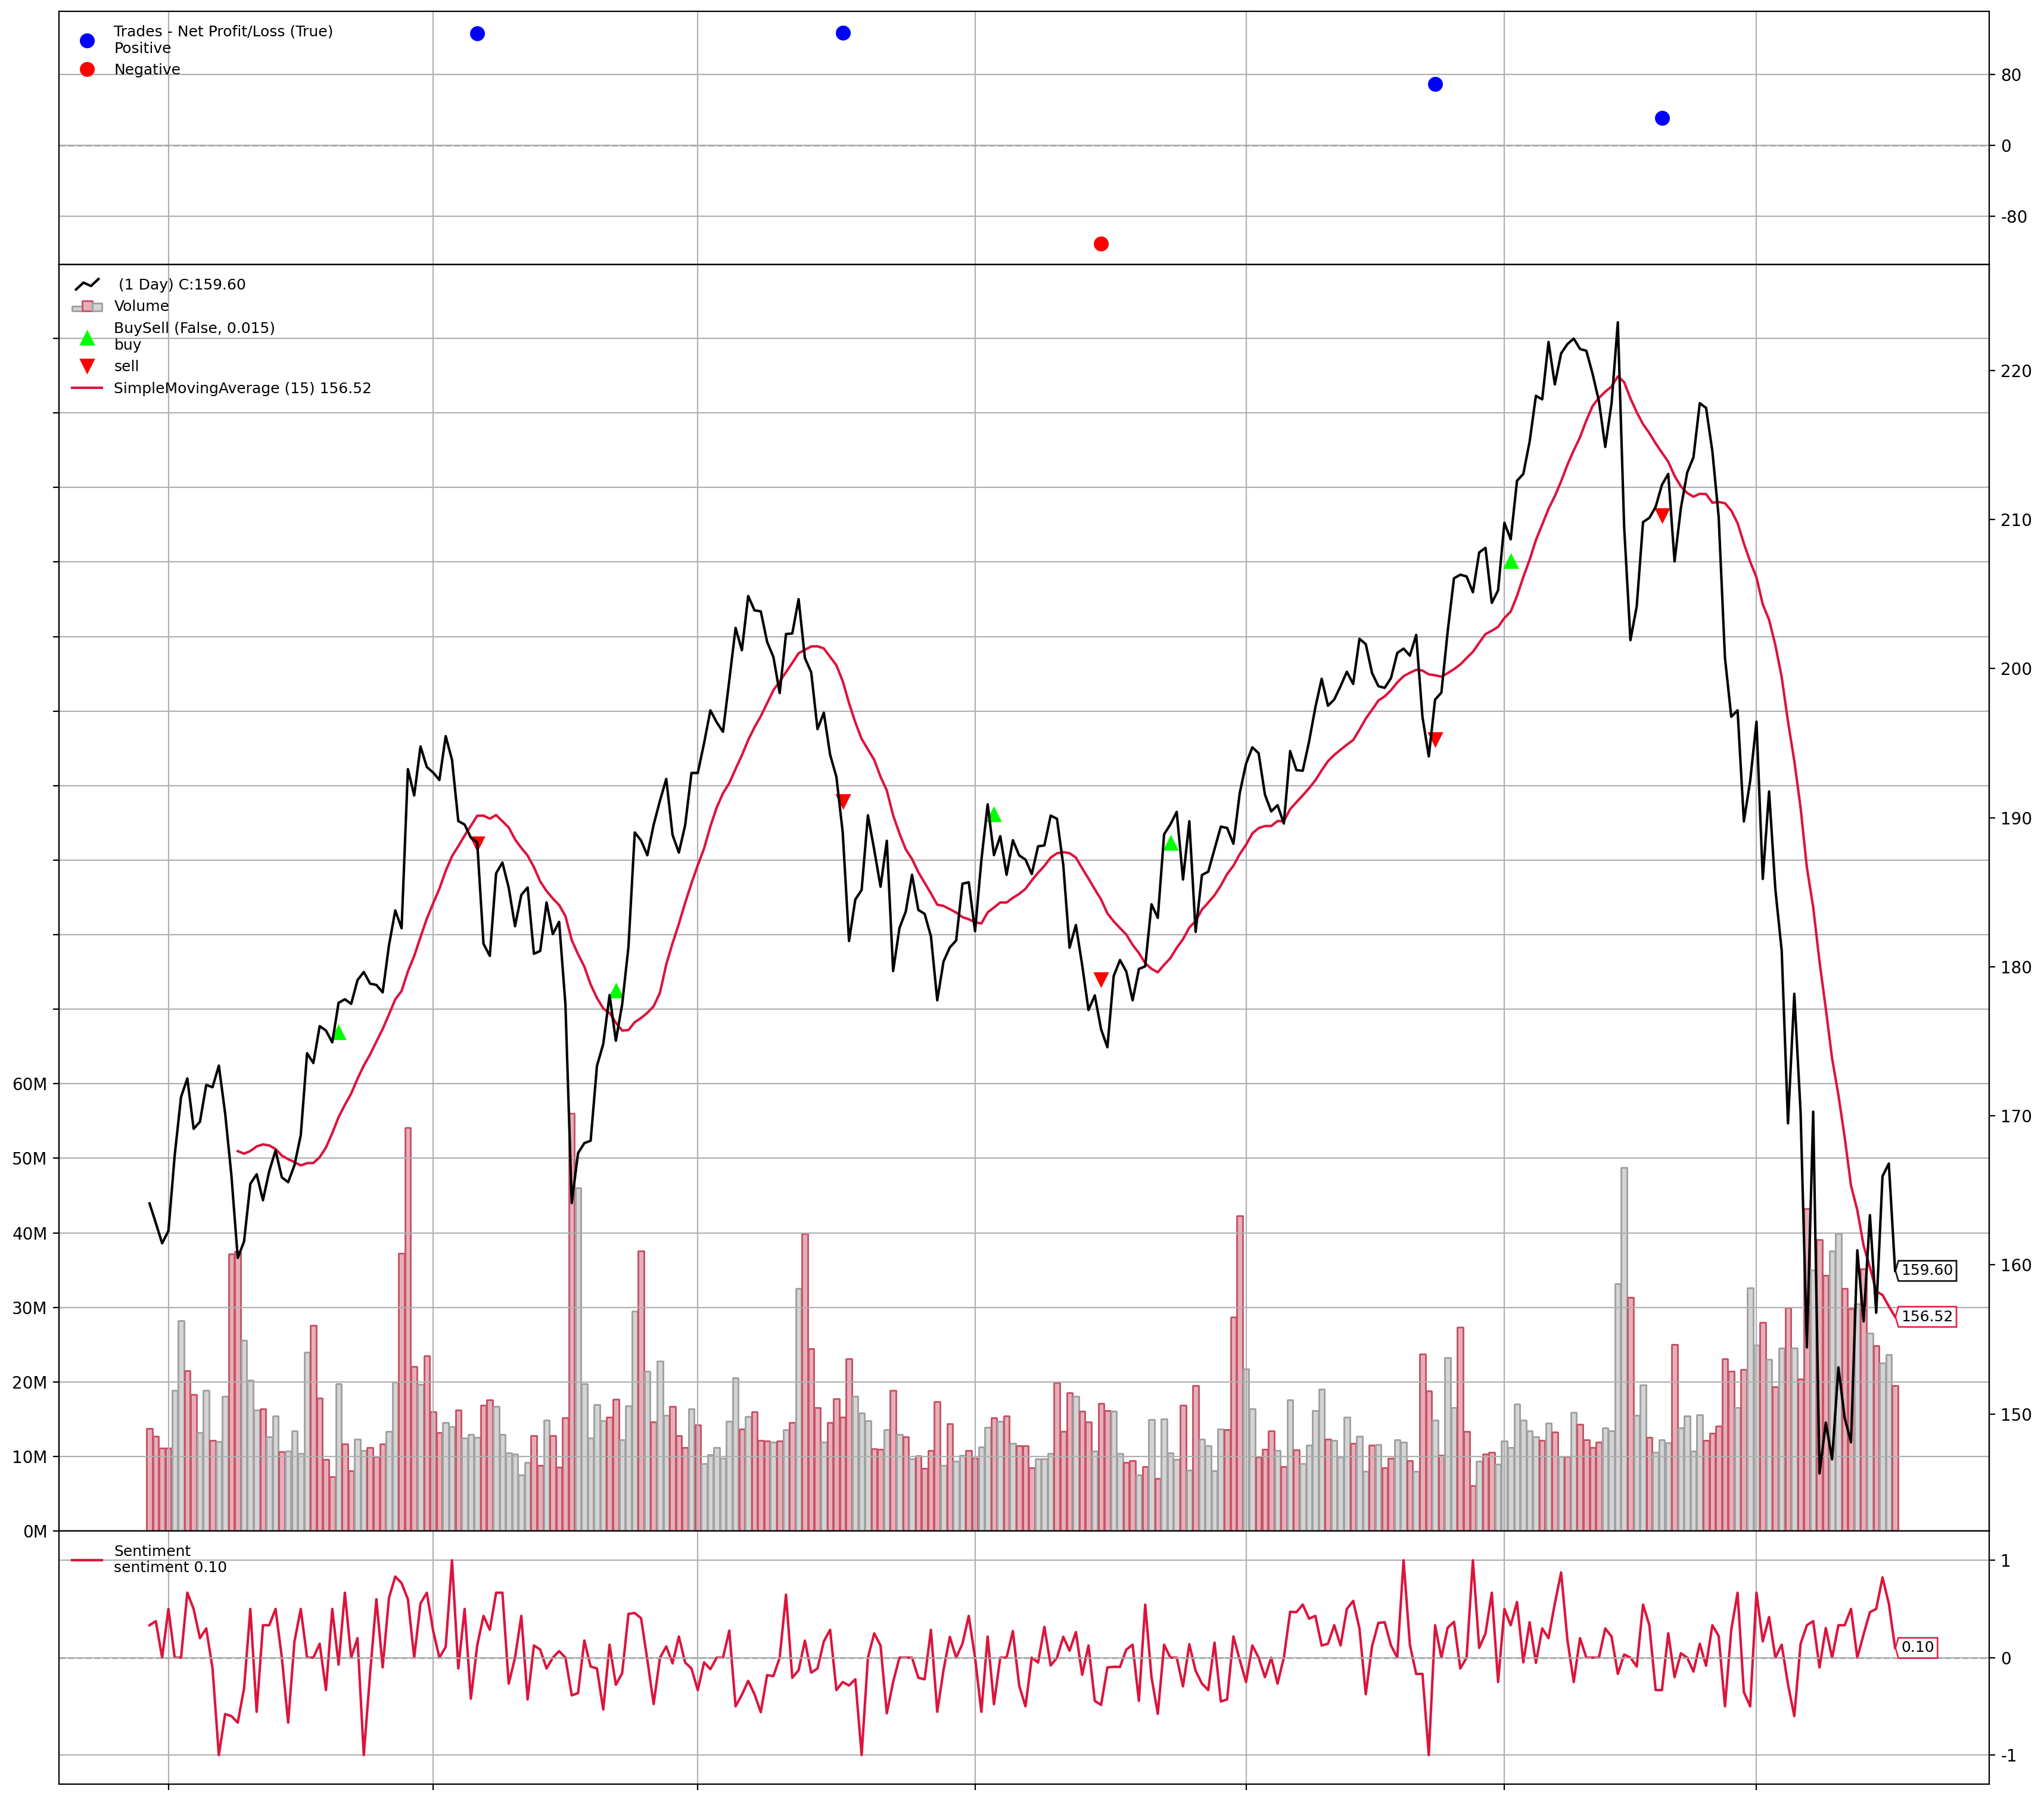

In [38]:
def saveplots(cerebro, numfigs=1, iplot=True, start=None, end=None,
             width=16, height=9, dpi=300, tight=True, use=None, file_path = '', **kwargs):

        from backtrader import plot
        if cerebro.p.oldsync:
            plotter = plot.Plot_OldSync(**kwargs)
        else:
            plotter = plot.Plot(**kwargs)

        figs = []
        for stratlist in cerebro.runstrats:
            for si, strat in enumerate(stratlist):
                rfig = plotter.plot(strat, figid=si * 100,
                                    numfigs=numfigs, iplot=iplot,
                                    start=start, end=end, use=use)
                figs.append(rfig)

        for fig in figs:
            for f in fig:
                f.savefig(file_path, bbox_inches='tight')
        return figs

saveplots(cerebro, file_path = 'savefig.png') #run it

In [6]:
nlp = en_core_web_lg.load()

In [22]:
text = """
Job Description

We are the FortiAI team, which oversees our new product line: FortiAI. It is a leading-edge product which utilizes machine learning technology for malware detection and instruction detection.

Job Responsibilities
• Research and develop new feature for FortiAI systems.
• Coordinates the product team with the latest machine learning technology.

Skills Required
• Familiar with C/C++ and databases
• Must be very familiar with developing and implementing machine learning algorithms
• Must have in-depth knowledge of Neural Network
• Experience working with Tensorflow, PyTorch, Mathlab, Cuda, etc
• Strong verbal and written communication skills
• Highly motivated and responsible quick learner

Education Requirement
• PhD in Mathematics, Computer science or equivalent experience
"""

doc = nlp(text)

In [24]:
for token in doc:
    if not token.is_stop:
        if token.pos_ != 'PUNCT':
            print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)


 
 SPACE _SP  
 False False
Job job NOUN NN compound Xxx True False
Description description NOUN NN ROOT Xxxxx True False


 

 SPACE _SP  

 False False
FortiAI FortiAI PROPN NNP compound XxxxxXX True False
team team NOUN NN attr xxxx True False
oversees oversee VERB VBZ relcl xxxx True False
new new ADJ JJ amod xxx True False
product product NOUN NN compound xxxx True False
line line NOUN NN dobj xxxx True False
FortiAI FortiAI PROPN NNP appos XxxxxXX True False
leading leading ADJ JJ amod xxxx True False
edge edge NOUN NN compound xxxx True False
product product NOUN NN attr xxxx True False
utilizes utilize VERB VBZ relcl xxxx True False
machine machine NOUN NN compound xxxx True False
learning learn VERB VBG compound xxxx True False
technology technology NOUN NN dobj xxxx True False
malware malware ADJ JJ amod xxxx True False
detection detection NOUN NN nmod xxxx True False
instruction instruction NOUN NN conj xxxx True False
detection detection NOUN NN pobj xxxx True False


 

 